In [1]:
import mxnet as mx
import cv2
from pathlib import Path
import os
from time import time
import pickle

In [2]:
def transform(data, label, augs):
    data = data.astype('float32')
    for aug in augs:
        data = aug(data)
    # from (H x W x c) to (c x H x W)
    data = mx.nd.transpose(data, (2,0,1))
    return data, mx.nd.array([label]).asscalar().astype('float32')

val_test_augs = [
    mx.image.CenterCropAug((224,224))
]

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    return fname

def classify_logo(net, url):
    fname = get_image(url)
    with open(fname, 'rb') as f:
        img = mx.image.imdecode(f.read())
    data, _ = transform(img, -1, val_test_augs)
    data = data.expand_dims(axis=0)
    out = net(data.as_in_context(ctx[0]))
    out = mx.nd.SoftmaxActivation(out)
    pred = int(mx.nd.argmax(out, axis=1).asscalar())
    prob = out[0][pred].asscalar()
    with open("label.pkl","rb") as f:
        label = pickle.load(f)
    return 'With prob=%f, %s'%(prob, label[pred])

In [4]:
from mxnet.gluon.model_zoo import vision as models

pretrained_net = models.resnet18_v2(pretrained=True)

In [5]:
ctx = [mx.cpu(i) for i in range(1)]

In [6]:
finetune_net = models.resnet18_v2(classes=33)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(mx.init.Xavier(magnitude=2.24))

In [7]:
finetune_net.collect_params().load('ft-%d.params'%(16),ctx)

'With prob=0.979992, ferrari'

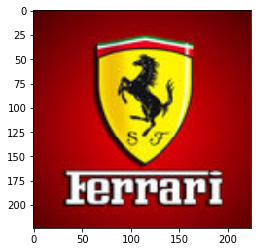

In [8]:
img_url = "http://www.freetexturesblueprints.com/albums/userpics/10001/thumb_ferrari-logo.jpg"
classify_logo(finetune_net, img_url)